In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sqlalchemy

from mplsoccer import Pitch
from sqlalchemy import create_engine, text

In [14]:
def db_conn(_username, _password, _host, _port, _database) : 
    db_engine = sqlalchemy.engine.URL.create(
        drivername = "mysql+pymysql",
        username = _username,
        password = _password,
        host = _host,
        port = _port,
        database = _database,
    )

    return create_engine(db_engine)

In [15]:
engine = db_conn('root', 'Dhyoon96!', 'localhost', 3306, 'side_proj_fco')
df_query = 'SELECT * FROM shoot_user_detail'

# Use the connection to read the SQL query into a DataFrame
with engine.connect() as connection:
    shoot_detail_df = pd.read_sql(df_query, con = connection)          

shoot_detail_df['shoot_time_10'] = shoot_detail_df['shoot_time'] // 60 // 10 * 10

In [16]:
shoot_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2323 entries, 0 to 2322
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   match_id          2323 non-null   object 
 1   user_ouid         2323 non-null   object 
 2   match_result      2323 non-null   object 
 3   shoot_result      2323 non-null   int64  
 4   shoot_time        2323 non-null   int64  
 5   shoot_position_x  2323 non-null   float64
 6   shoot_position_y  2323 non-null   float64
 7   shoot_assist      2323 non-null   int64  
 8   shoot_assist_X    2323 non-null   float64
 9   shoot_assist_Y    2323 non-null   float64
 10  shoot_inpenalty   2323 non-null   int64  
 11  shoot_time_10     2323 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 217.9+ KB


In [17]:
shoot_detail_df['shoot_result'].value_counts()

shoot_result
1    1016
3     674
2     633
Name: count, dtype: int64

In [18]:
pitch_half = Pitch(pitch_type = 'metricasports', 
                   pitch_length = 105, pitch_width = 68,
                   positional = True,
                   corner_arcs = True,
                   axis = True, half = True)

pitch_full = Pitch(pitch_type = 'metricasports', 
                   pitch_length = 105, pitch_width = 68,
                   positional = True,
                   corner_arcs = True,
                   axis = True)

shoots_goal = shoot_detail_df[(shoot_detail_df['shoot_result'] == 3)]
shoots_eff = shoot_detail_df[(shoot_detail_df['shoot_result'] == 1)]
shoots_noeff = shoot_detail_df[(shoot_detail_df['shoot_result'] == 2)]

goal_assist = shoot_detail_df[(shoot_detail_df['shoot_assist'] == 1) & 
                               (shoot_detail_df['shoot_result'] == 3)]

goal_assist_outpenalty = goal_assist[(goal_assist['shoot_inpenalty'] == 0)]
goal_assist_inpenalty = goal_assist[(goal_assist['shoot_inpenalty'] == 1)]         

# Time for shoot & goal

In [19]:
def list_to_10(_df1) : 
    temp_count = list(_df1['shoot_time_10'].value_counts().sort_index().values)

    while len(temp_count) < 13:
        temp_count.append(0)

    return temp_count

In [20]:
shoot_count = list_to_10(shoot_detail_df)
shoots_eff_count = list_to_10(shoots_eff)
shoots_noeff_count = list_to_10(shoots_noeff)
goal_count = list_to_10(shoots_goal)

In [21]:
shoot_count

[193, 261, 232, 240, 312, 250, 217, 248, 240, 116, 5, 6, 3]

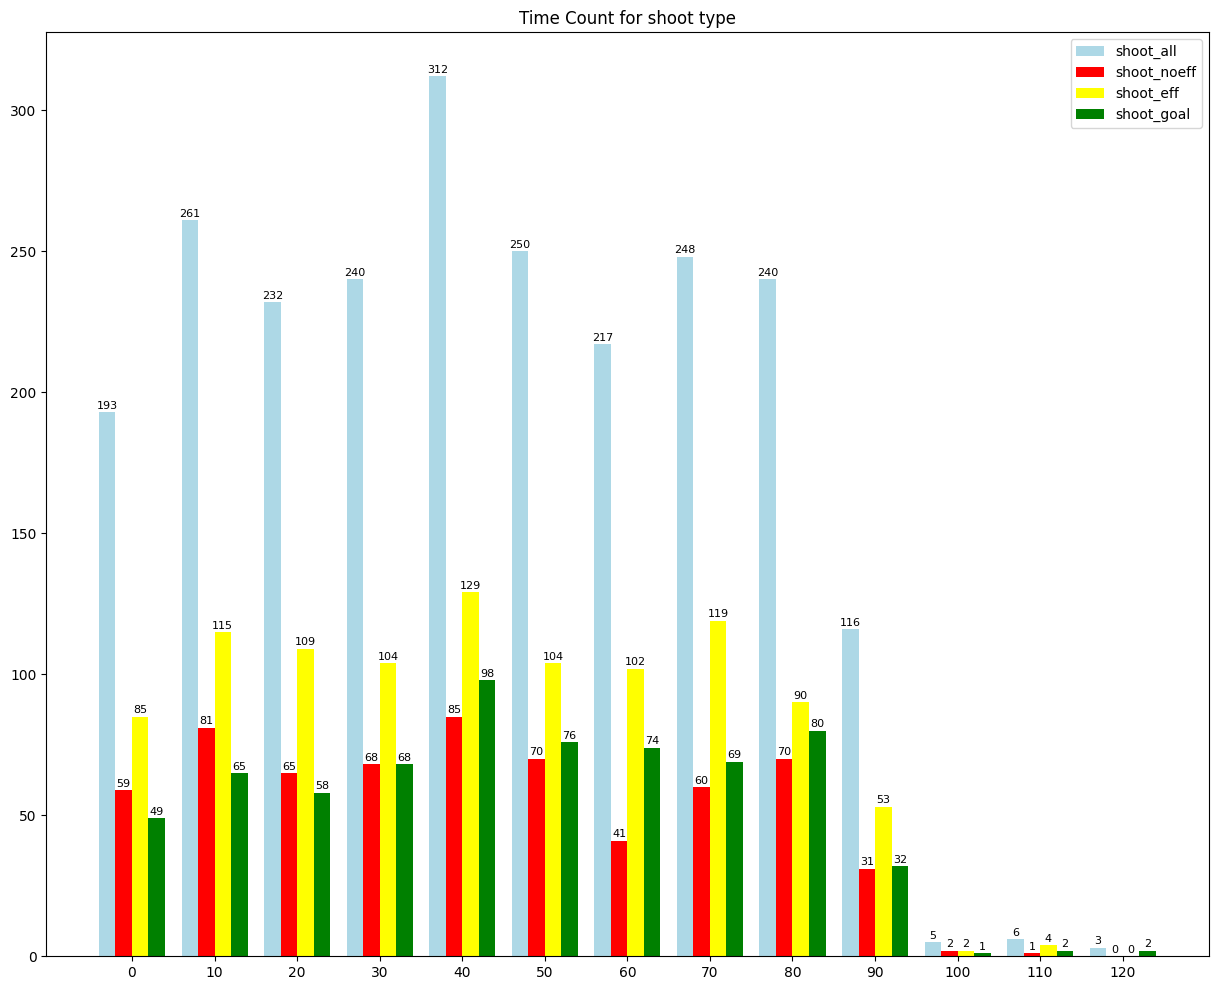

In [22]:
plt.figure(figsize = (15, 12))

x_axis = np.arange(0, 130, 10)
width = 2

bars1 = plt.bar(x_axis - width * 3 // 2, shoot_count, width = width, label = 'shoot_all', color = 'lightblue')
bars2 = plt.bar(x_axis - width // 2, shoots_noeff_count, width = width, label = 'shoot_noeff', color = 'red')
bars3 = plt.bar(x_axis + width // 2, shoots_eff_count, width = width, label = 'shoot_eff', color = 'yellow')
bars4 = plt.bar(x_axis + width * 3 // 2, goal_count, width = width, label = 'shoot_goal', color = 'green')

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            f'{int(bar.get_height())}',
            ha = 'center', va = 'bottom', fontsize = 8
        )

plt.title('Time Count for shoot type')
plt.xticks(x_axis, x_axis)
plt.legend(loc = 'upper right')
plt.show()

# Shoot & Goal Heatmap 

In [23]:
def shoot_goal_heatmap(_df, _ax, _ptich_type, str1) : 
    bin_statistic_assist = _ptich_type.bin_statistic_positional(_df['shoot_position_x'], _df['shoot_position_y'], 
                                                                statistic = 'count',
                                                                positional = 'full', normalize = True)

    _ptich_type.heatmap_positional(bin_statistic_assist, ax = _ax, cmap = 'coolwarm', edgecolors = '#22312b')
    _ptich_type.scatter(_df['shoot_position_x'], _df['shoot_position_y'], c = 'green', alpha = 0.6, s = 5, ax = _ax)

    labels = _ptich_type.label_heatmap(bin_statistic_assist, color = 'black', fontsize = 10,
                                       ax = _ax, ha = 'center', va = 'center',
                                       str_format='{:.0%}')

    _ax.set_title(f"Heatmap for {str1}_count {len(_df)}", fontsize = 10)

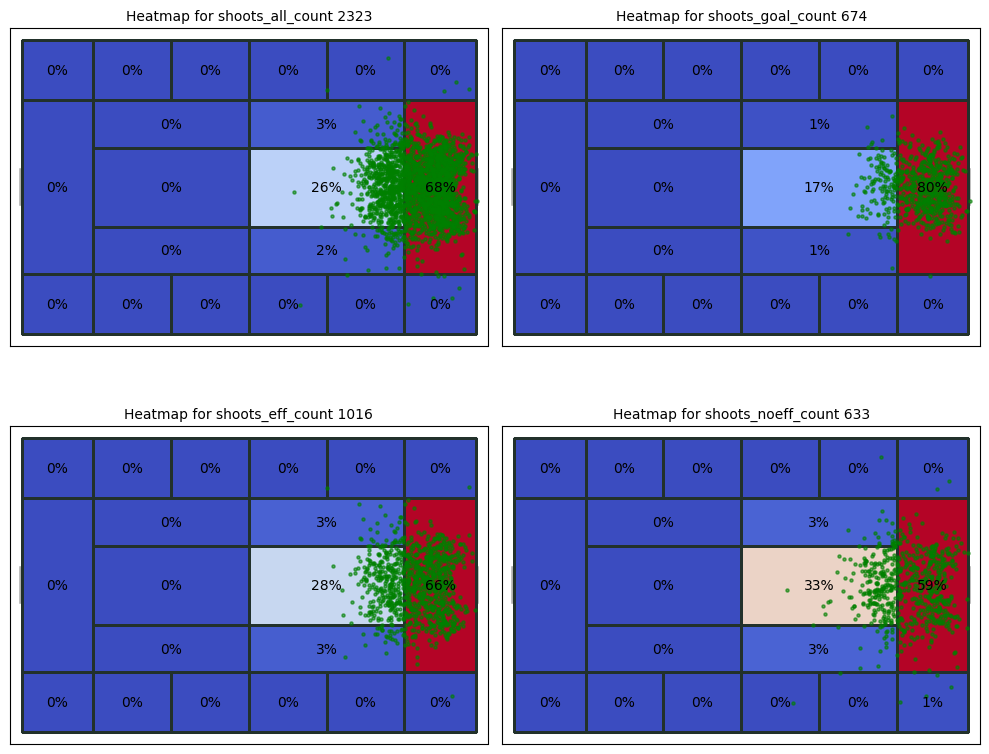

In [24]:
fig, ax = pitch_full.draw(figsize=(10, 10), ncols = 2, nrows = 2)

shoot_goal_heatmap(shoot_detail_df, ax[0][0], pitch_full, 'shoots_all')
shoot_goal_heatmap(shoots_goal, ax[0][1], pitch_full, 'shoots_goal')
shoot_goal_heatmap(shoots_eff, ax[1][0], pitch_full, 'shoots_eff')
shoot_goal_heatmap(shoots_noeff, ax[1][1], pitch_full, 'shoots_noeff')

# Assist Heatmap and Arrow for goal type

In [25]:
def shoot_assist_heatmap(_df, _ax, _ptich_type, str1) : 
    # Assist Heatmap
    bin_statistic_assist = _ptich_type.bin_statistic_positional(_df['shoot_assist_X'], _df['shoot_assist_Y'], 
                                                                statistic = 'count',
                                                                positional = 'full', normalize = True)

    _ptich_type.heatmap_positional(bin_statistic_assist, ax = _ax[0], cmap = 'coolwarm', edgecolors = '#22312b')
    _ptich_type.scatter(_df['shoot_assist_X'], _df['shoot_assist_Y'], c = 'green', alpha = 0.6, s = 5, ax = _ax[0])

    labels = _ptich_type.label_heatmap(bin_statistic_assist, color = 'black', fontsize = 10,
                                       ax = _ax[0], ha = 'center', va = 'center',
                                       str_format='{:.0%}')

    _ax[0].set_title(f"Heatmap for {str1}_goal {len(_df)}", fontsize = 10)

    # Assist Arrow
    _ptich_type.scatter(_df['shoot_assist_X'], _df['shoot_assist_Y'], color = 'green',  s = 5, ax = _ax[1])
    _ptich_type.scatter(_df['shoot_position_x'], _df['shoot_position_y'], color = 'blue', s = 7, ax = _ax[1])
    
    _ptich_type.arrows(_df['shoot_assist_X'], _df['shoot_assist_Y'],
                       _df['shoot_position_x'], _df['shoot_position_y'], width = 1,
                       headwidth = 5, headlength = 5, alpha = 0.5, color = '#ad993c', ax = _ax[1])

    _ax[1].set_title(f"Arrow for {str1}_goal {len(_df)}", fontsize = 10)

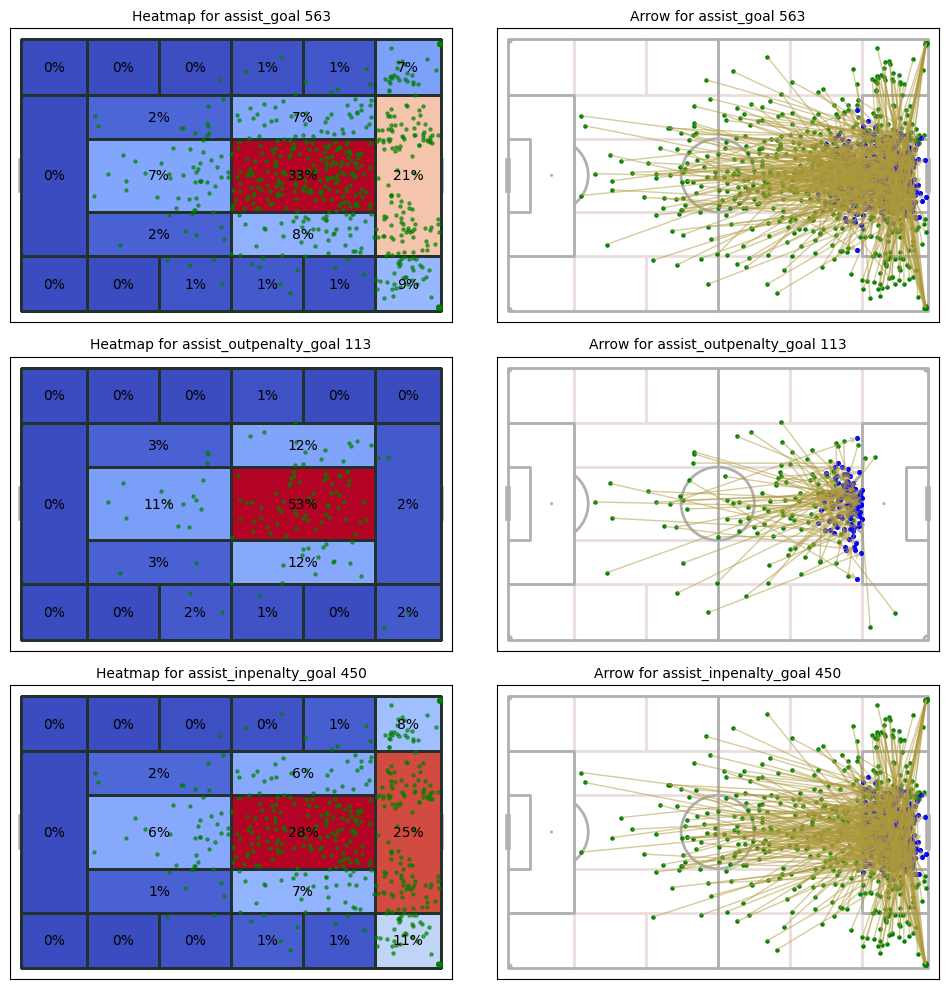

In [26]:
fig, ax = pitch_full.draw(figsize=(10, 10), ncols = 2, nrows = 3)

shoot_assist_heatmap(goal_assist, ax[0], pitch_full, 'assist')
shoot_assist_heatmap(goal_assist_outpenalty, ax[1], pitch_full, 'assist_outpenalty')
shoot_assist_heatmap(goal_assist_inpenalty, ax[2], pitch_full, 'assist_inpenalty')

plt.show()